# Visualize UNet
*3 Feb 2022*

In [11]:
%%time
import numpy as np
import matplotlib.pyplot as plt

import os
import sys

from scipy.special import softmax

import torch
from torch.utils.data import Dataset, DataLoader, Subset

from SegmentationUtilities import UNet, CustomDatasetLayered2, get_paddings
from SegmentationUtilities import translate_dict
from SegmentationUtilities import DatasetNoMassClass

#from MultiScaleAttention.src.models.my_stacked_danet import DAF_stack
# from SmaAtUNet.models.SmaAt_UNet import SmaAt_UNet
# from SmaAtUNetNoDrop.models.SmaAt_UNet import SmaAt_UNet as SmaAt_UNet_NoDrop
# from SmaAtUNet.models.SmaAt_UNet_doublechannel import SmaAt_UNet_doublechannel
# from SmaAtUNet.models.SmaAt_UNet_extralevel import SmaAt_UNet_extralevel

from IPython.display import Audio

# from bl_unet import custom_unet
# from bl_unet import UNetDataset

from bl_bigkerunet import model_generator_generator as bigker_gg
# from bl_avgpool import model_generator_generator as avgpool_gg
# from brain_unet import BrainUNet

CPU times: user 42 µs, sys: 6 µs, total: 48 µs
Wall time: 51.5 µs


(Note that "bigker" just means that the model takes kernel size as a hyperparameter.)

## Model

In [12]:
!ls -lht Models | grep -v 'chk_'

total 342M
-rw-r--r--. 1 atsang dvorkin_lab  23M Jul 15 10:51 bigkerUNet_bl_cat_exp10_c25_br20_nsub1_hst_5e5_drop10_b16_f32_k3.tar
-rw-r--r--. 1 atsang dvorkin_lab  23M Jul 15 10:20 bigkerUNet_bl_cat_exp10_c45_br20_nsub1_hst_5e5_drop10_b16_f32_k3.tar
-rw-r--r--. 1 atsang dvorkin_lab  23M Jul 13 16:38 bigkerUNet_bl_cat_exp10_c25_br20_nsub1_hstelt3_5e5_drop10_b16_f32_k3.tar
-rw-r--r--. 1 atsang dvorkin_lab  23M Jul 13 00:53 bigkerUNet_bl_cat_exp10_c45_br20_nsub1_hstelt3_5e5_drop10_b16_f32_k3.tar
-rw-r--r--. 1 atsang dvorkin_lab  23M Jul  3 21:42 bigkerUNet_bl_cat_exp1_c60_br20_nsub1_hstelt_5e5_drop10_b16_f32_k3.tar
-rw-r--r--. 1 atsang dvorkin_lab  23M Jul  1 08:59 bigkerUNet_bl_cat_exp1_c60_br20_nsub1_hst_5e5_drop10_b16_f32_k3.tar
-rw-r--r--. 1 atsang dvorkin_lab  23M Jun 29 17:13 bigkerUNet_bl_cat_sub_m8m11ninety_noise1_c60_hstelt3_5e5_drop10_b16_f32_k3.tar
-rw-r--r--. 1 atsang dvorkin_lab  23M May 13 15:33 bigkerUNet_hstelt3_f32_k3.tar
-rw-r--r--. 1 atsang dvorkin_lab  314 May 13 15:2

In [17]:
mname = 'bigkerUNet_bl_cat_exp10_c45_br20_nsub1_hst_5e5_drop10_b16_f32_k3'
maxlen = int(5e5)

In [18]:
fine_tuning = False

if fine_tuning:
    loaded_freeze = torch.load('Models/{}.tar'.format(mname_freeze),
                                  map_location=torch.device('cpu'))

loaded = torch.load('Models/{}.tar'.format(mname),
                    map_location=torch.device('cpu'))

best_i = None
for i in range(len(loaded['model_state_dict'])):
    if loaded['model_state_dict'][i] is not None:
        print(i)
        if best_i is None:
            best_i = i

9
15


In [19]:
loaded.keys()

dict_keys(['epoch', 'model_state_dict', 'optimizer_state_dict', 'TrainingLoss', 'ValidationLoss'])

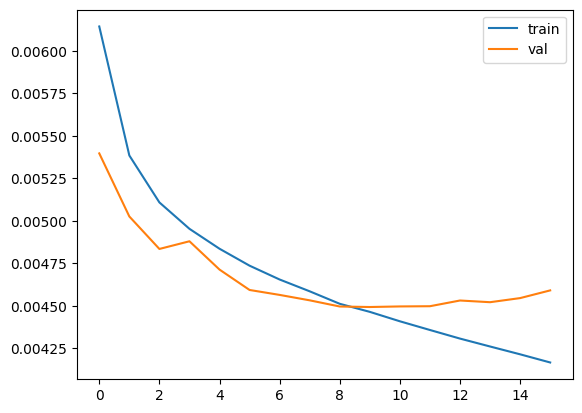

In [20]:
plt.plot(loaded['TrainingLoss'], label='train')
plt.plot(loaded['ValidationLoss'], label='val')
plt.legend()

In [9]:
### Make model

n_class = 2
if 'brainUNet' in mname:
    assert mname.split('_')[-1][0] == 'f'
    fac = int(mname.split('_')[-1][1:])
    model = BrainUNet(1, 2, init_features=fac)
elif 'avgpoolUNet' in mname:
    pdrop = .1
    assert mname.split('_')[-2][0] == 'f'
    assert mname.split('_')[-1][0] == 'k'
    fac = int(mname.split('_')[-2][1:])
    ker = int(mname.split('_')[-1][1:])
    model = avgpool_gg(fac, ker)(1, 2, pdrop)
elif 'bigker' in mname:
    pdrop = .1
    assert mname.split('_')[-2][0] == 'f'
    assert mname.split('_')[-1][0] == 'k'
    fac = int(mname.split('_')[-2][1:])
    ker = int(mname.split('_')[-1][1:])
    model = bigker_gg(fac, ker)(1, 2, pdrop)
elif 'SmaAt' not in mname:
    pdrop = 0
    model = custom_unet(n_class, pdrop)
elif 'SmaAtel' in mname:
    pdrop = 0.1
    fac_tmp = mname.split('_')[-1]
    assert fac_tmp[0] == 'f'
    fac = int(fac_tmp[1:])
    model = SmaAt_UNet_extralevel(1, n_class, pdrop=pdrop, fac=fac)
else:
    print('using SmaAt_UNet')
    pdrop = 0.1
    model = SmaAt_UNet(1, n_class, pdrop=pdrop)

model.load_state_dict(translate_dict(loaded['model_state_dict'][best_i]))
model.eval();

## Recorded losses

In [6]:
print('final losses -- train:', loaded['TrainingLoss'][best_i],
      'and validation:', loaded['ValidationLoss'][best_i])

final losses -- train: 0.00034101635760976935 and validation: 0.0003419852408231236


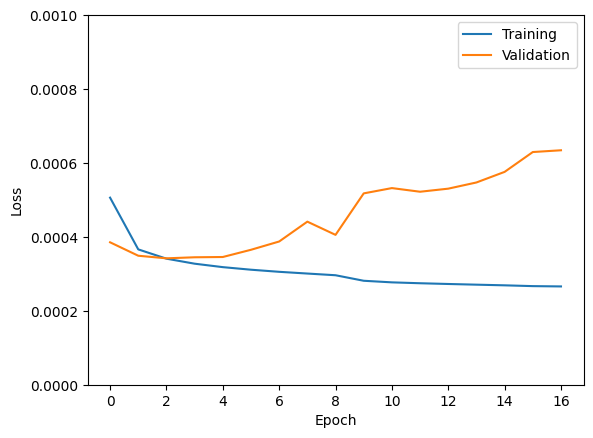

In [7]:
#plt.gca().set_yscale('log')

if fine_tuning:
    ## For plotting fine-tuning loss curves
    plt.plot(loaded_freeze['TrainingLoss'] + loaded['TrainingLoss'], label='Training')
    plt.plot(loaded_freeze['ValidationLoss'] + loaded['ValidationLoss'], label='Validation')
    plt.axvline(len(loaded_freeze['TrainingLoss']) - 1, ls='--', c='k')
    
else:
    plt.plot(loaded['TrainingLoss'], label='Training')
    plt.plot(loaded['ValidationLoss'], label='Validation')

#plt.ylim(0,None)

    
plt.xlabel('Epoch')
plt.ylabel('Loss')

#plt.title('UNet on 10^9-10^11: Dropout {}%'.format(int(100*pdrop)))
#plt.title('Higher resolution: 0.02 arcsec', fontsize=14)
#plt.title('Concentration 60', fontsize=14)

plt.ylim(0,.001)
#plt.ylim(0, .01)

plt.legend()
#plt.savefig('imgs/loss_hstelt3c15.png')

## Data

Remember to change this manually!

In [8]:
# ## Final version (to visualize the val set)
if 'hstelt3' in mname:
    print('Using HSTELT3 data to visualize')
    train_postfix = 'cattrain_sub_m8m11ninety_noise10_c60_hstelt3'
    val_postfix = 'catval_sub_m8m11ninety_noise10_c60_hstelt3'
    
    in_folders = [['in_' + train_postfix], ['in_' + val_postfix]]
    out_folders = [['coord_' + train_postfix], ['coord_' + val_postfix]]
    # no longer need to say "coordwide"
    
    in_size = 640
    pixsize = .01
    
    root_dir = '/n/holyscratch01/dvorkin_lab/Users/atsang/mif'
else:
    print('Using HSTELT data to visualize')

    train_postfix = 'cattrain_sub_m8m11ninety_noise10_c60_hstelt'
    val_postfix = 'catval_sub_m8m11ninety_noise10_c60_hstelt'
    
    in_folders = [['in_' + train_postfix], ['in_' + val_postfix]]
    out_folders = [['coord_' + train_postfix], ['coord_' + val_postfix]]
    
    in_size = 320
    pixsize = .02
    
    root_dir = '/n/holyscratch01/dvorkin_lab/Users/atsang/mif'

Using HSTELT3 data to visualize


In [9]:
train_dataset = DatasetNoMassClass(root_dir, in_folders[0], out_folders[0],
                             ytypes=[torch.IntTensor],
                             maxlen=maxlen,
                             in_size=in_size)
val_dataset = DatasetNoMassClass(root_dir, in_folders[1], out_folders[1],
                             ytypes=[torch.IntTensor],
                             maxlen=maxlen,
                             in_size=in_size)

## Visualizations

In [10]:
maxlen

500000

In [11]:
## Data loader
batch_size = 1
#data_offset = 1000000 if maxlen == 500000 else 100000
data_offset = 1000000
n_val = maxlen // 10

train_subset = Subset(train_dataset, range(maxlen))
train_loader = DataLoader(train_subset, batch_size=batch_size)

val_subset = Subset(val_dataset, range(data_offset, data_offset + n_val))
val_loader = DataLoader(val_subset, batch_size=batch_size)

In [12]:
#coord_folder = os.path.join(root_dir, 'coord_' + folder_postfix)

In [13]:
def simple_div(x, y, pixsize=.08):
    #return (x[2:,1:-1] - x[:-2,1:-1])/(2*pixsize) + (y[1:-1,2:] - y[1:-1,:-2])/(2*pixsize)
    offx = (-1./12.)*(x[4:,2:-2] - x[:-4,2:-2])+(2./3.)*(x[3:-1,2:-2] - x[1:-3,2:-2])
    offy = (-1./12.)*(y[2:-2,4:] - y[2:-2,:-4])+(2./3.)*(y[2:-2,3:-1] - y[2:-2,1:-3])
    return (offx+offy)/pixsize
def simple_curl(x, y, pixsize=.08):
    #return (y[2:,1:-1] - y[:-2,1:-1])/(2*pixsize) - (x[1:-1,2:] - x[1:-1,:-2])/(2*pixsize)
    offx = (-1./12.)*(x[2:-2,4:] - x[2:-2,:-4])+(2./3.)*(x[2:-2,3:-1] - x[2:-2,1:-3])
    offy = (-1./12.)*(y[4:,2:-2] - y[:-4,2:-2])+(2./3.)*(y[3:-1,2:-2] - y[1:-3,2:-2])
    return (offy-offx)/pixsize

In [14]:
# from pipeline import make_gaussian_kernel
# from scipy.signal import convolve2d

# gaussian_kernel = make_gaussian_kernel(sigma=5)

mass bin 6
x shape torch.Size([1, 1, 640, 640])
out_tens torch.Size([1, 2, 640, 640]) torch.float32
label 1 torch.Size([1, 640, 640]) torch.int32


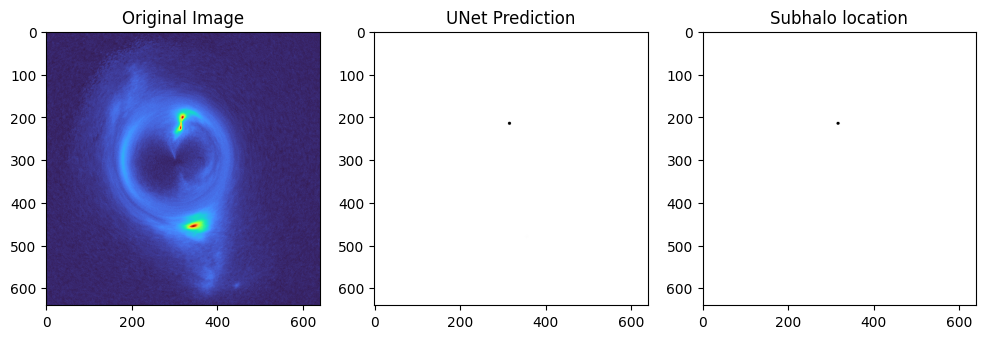

loss tensor(0.0001)
mass bin 2
x shape torch.Size([1, 1, 640, 640])
out_tens torch.Size([1, 2, 640, 640]) torch.float32
label 1 torch.Size([1, 640, 640]) torch.int32


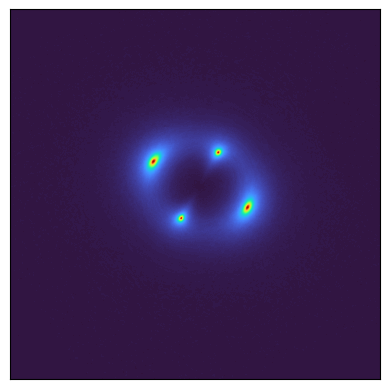

loss tensor(0.0004)
mass bin 3
x shape torch.Size([1, 1, 640, 640])
out_tens torch.Size([1, 2, 640, 640]) torch.float32
label 1 torch.Size([1, 640, 640]) torch.int32


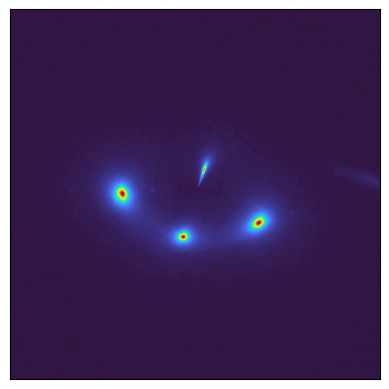

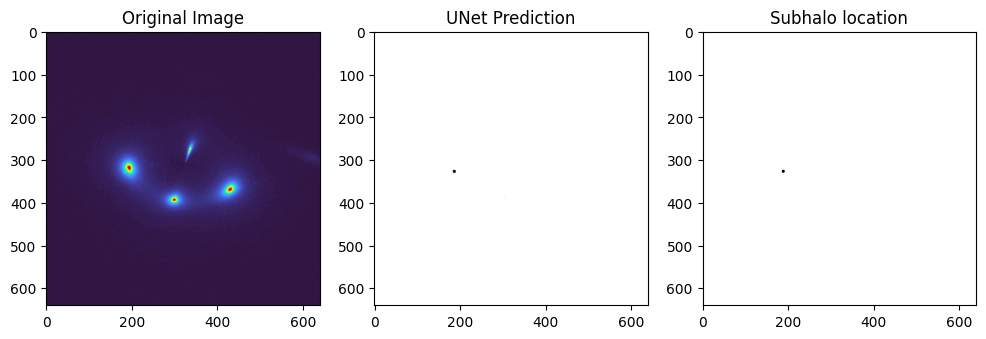

loss tensor(3.9128e-05)
mass bin 2
x shape torch.Size([1, 1, 640, 640])
out_tens torch.Size([1, 2, 640, 640]) torch.float32
label 1 torch.Size([1, 640, 640]) torch.int32


loss tensor(0.0007)
mass bin 3
x shape torch.Size([1, 1, 640, 640])
out_tens torch.Size([1, 2, 640, 640]) torch.float32
label 1 torch.Size([1, 640, 640]) torch.int32


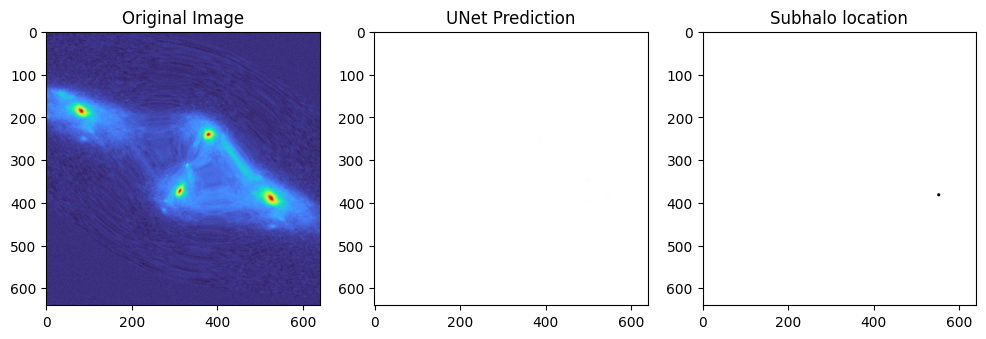

loss tensor(0.0006)
mass bin 6
x shape torch.Size([1, 1, 640, 640])
out_tens torch.Size([1, 2, 640, 640]) torch.float32
label 1 torch.Size([1, 640, 640]) torch.int32


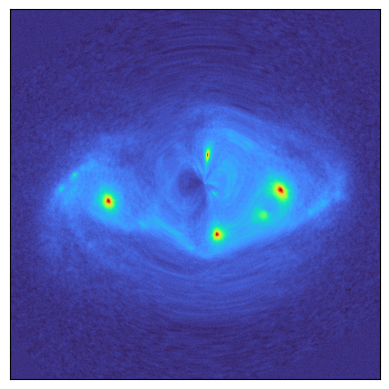

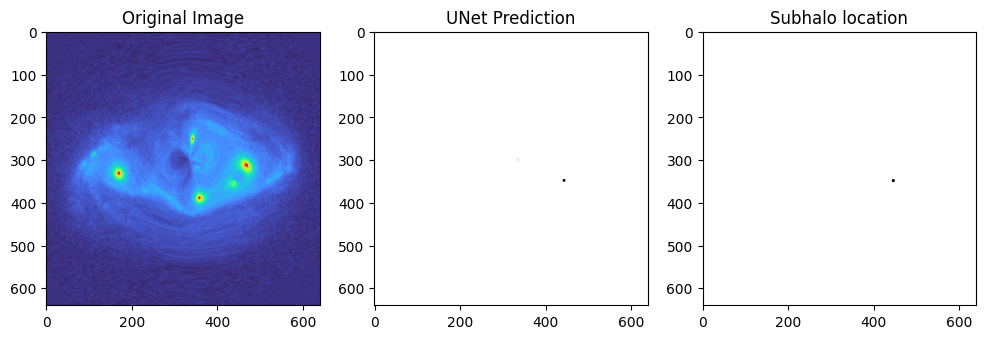

loss tensor(0.0001)
mass bin 3
x shape torch.Size([1, 1, 640, 640])
out_tens torch.Size([1, 2, 640, 640]) torch.float32
label 1 torch.Size([1, 640, 640]) torch.int32


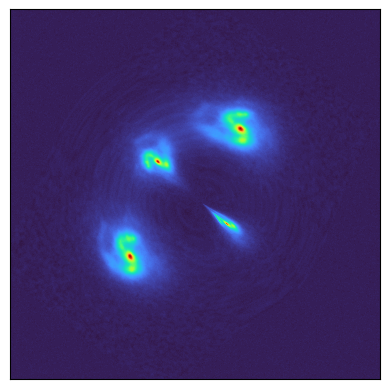

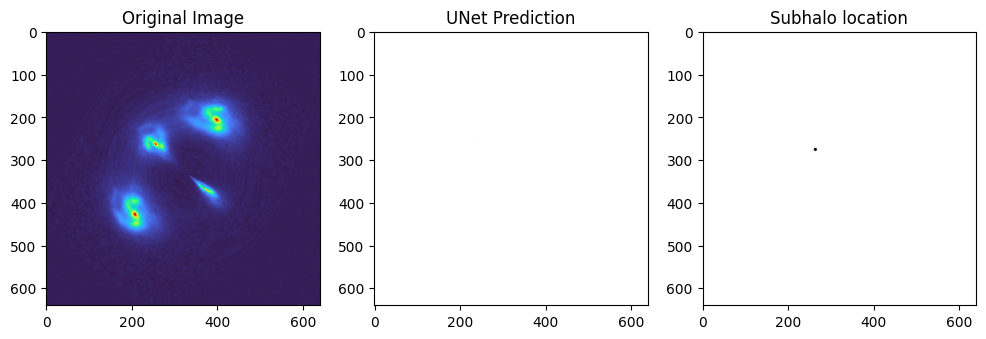

loss tensor(0.0008)
mass bin 3
x shape torch.Size([1, 1, 640, 640])
out_tens torch.Size([1, 2, 640, 640]) torch.float32
label 1 torch.Size([1, 640, 640]) torch.int32


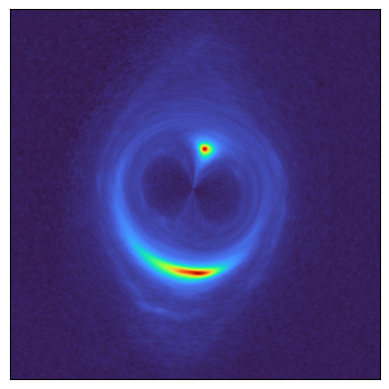

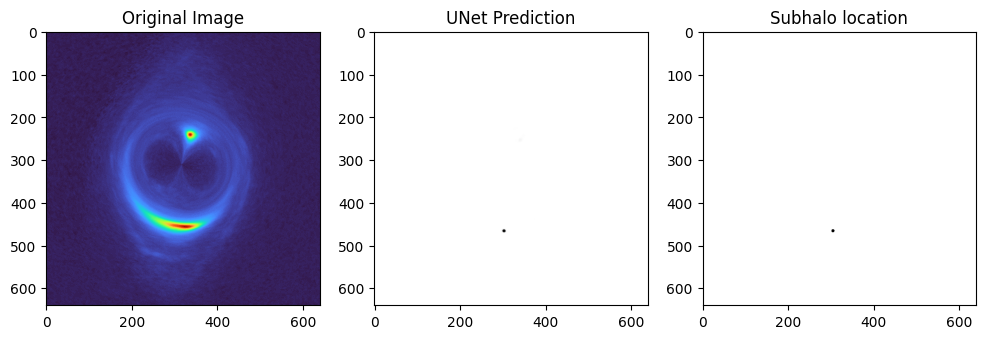

loss tensor(7.6821e-05)
mass bin 2
x shape torch.Size([1, 1, 640, 640])
out_tens torch.Size([1, 2, 640, 640]) torch.float32
label 1 torch.Size([1, 640, 640]) torch.int32


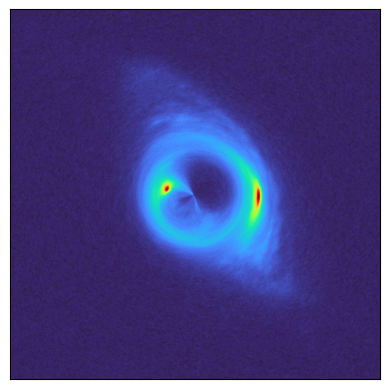

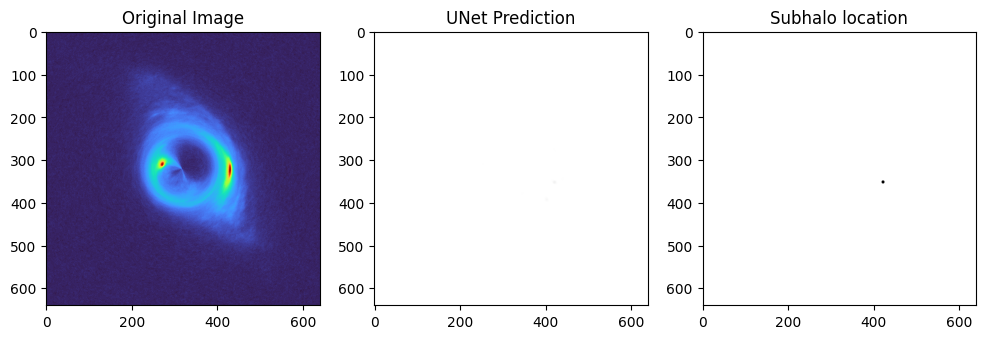

loss tensor(0.0003)
mass bin 5
x shape torch.Size([1, 1, 640, 640])
out_tens torch.Size([1, 2, 640, 640]) torch.float32
label 1 torch.Size([1, 640, 640]) torch.int32


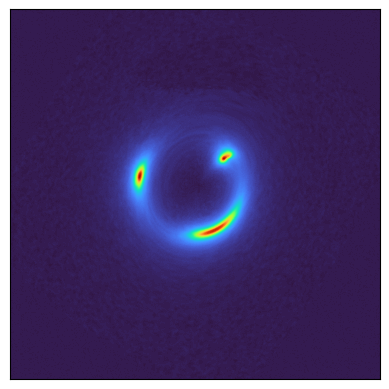

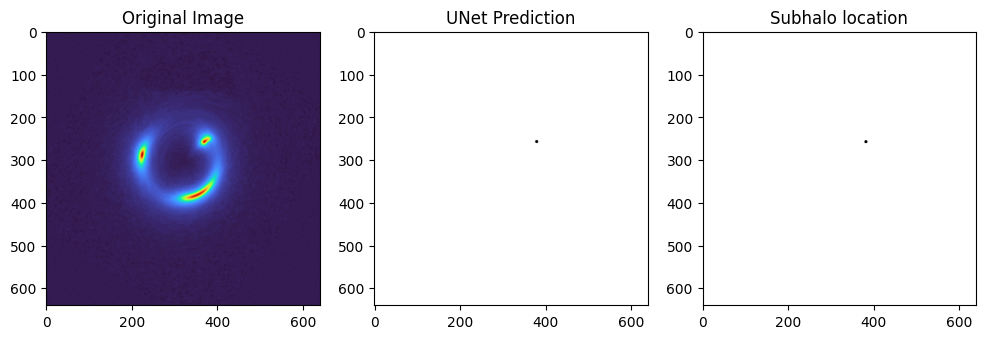

loss tensor(4.2307e-05)
mass bin 3
x shape torch.Size([1, 1, 640, 640])
out_tens torch.Size([1, 2, 640, 640]) torch.float32
label 1 torch.Size([1, 640, 640]) torch.int32


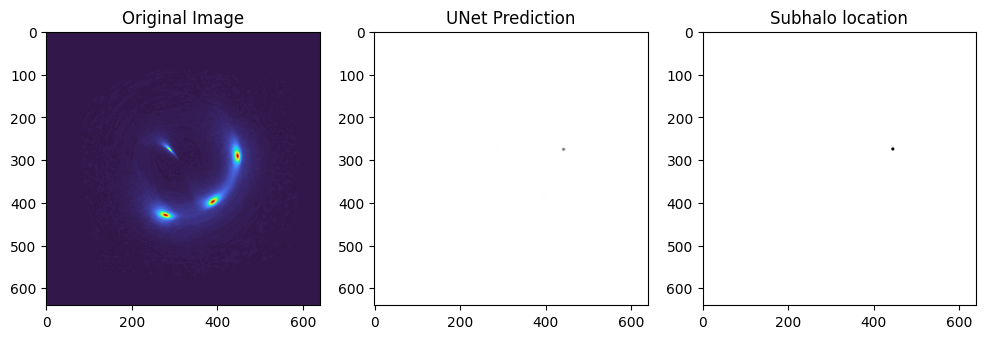

loss tensor(0.0001)
mass bin 2
x shape torch.Size([1, 1, 640, 640])
out_tens torch.Size([1, 2, 640, 640]) torch.float32
label 1 torch.Size([1, 640, 640]) torch.int32


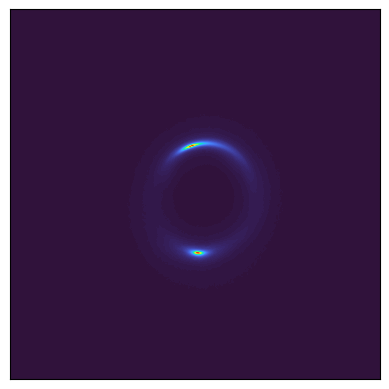

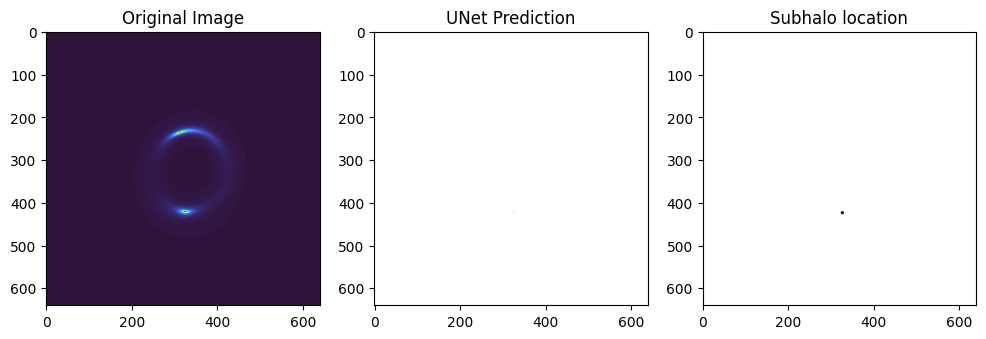

loss tensor(0.0004)
mass bin 2
x shape torch.Size([1, 1, 640, 640])
out_tens torch.Size([1, 2, 640, 640]) torch.float32
label 1 torch.Size([1, 640, 640]) torch.int32


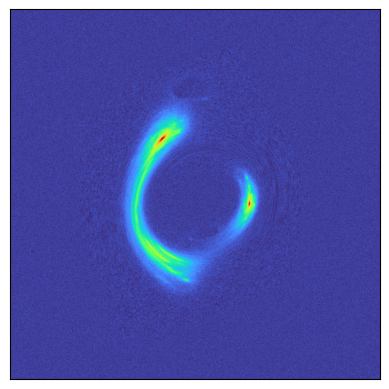

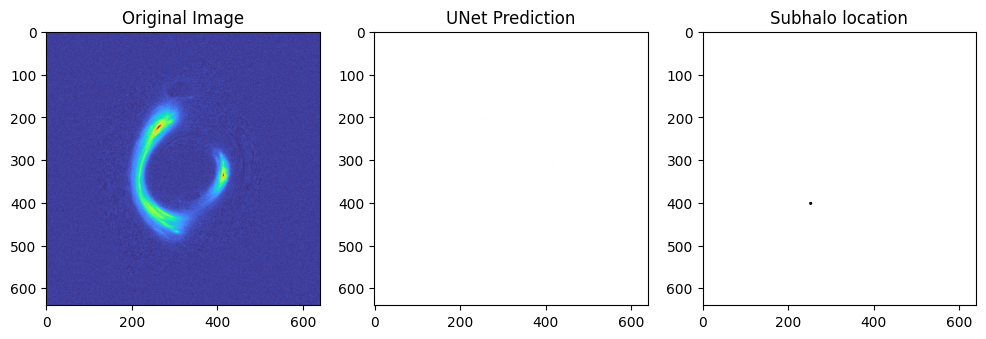

loss tensor(0.0008)
mass bin 2
x shape torch.Size([1, 1, 640, 640])
out_tens torch.Size([1, 2, 640, 640]) torch.float32
label 1 torch.Size([1, 640, 640]) torch.int32


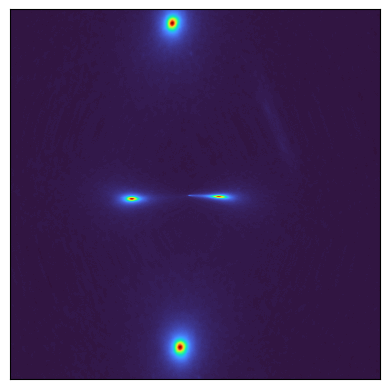

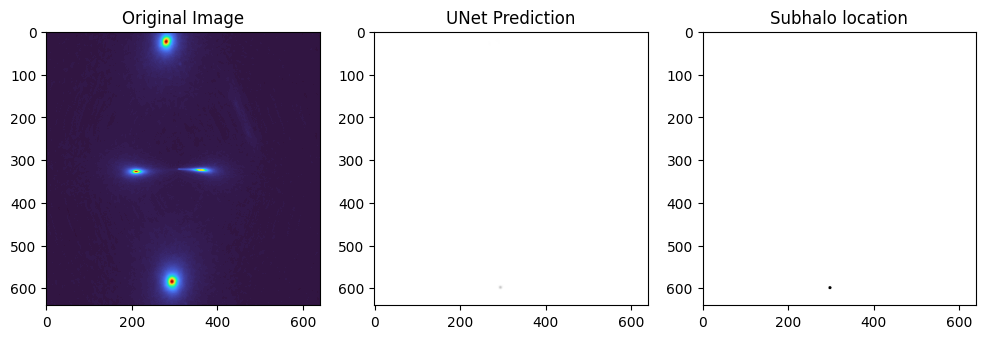

loss tensor(0.0002)
mass bin 2
x shape torch.Size([1, 1, 640, 640])
out_tens torch.Size([1, 2, 640, 640]) torch.float32
label 1 torch.Size([1, 640, 640]) torch.int32


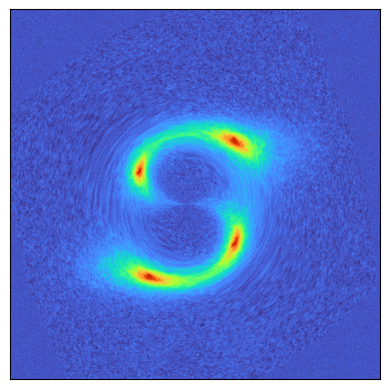

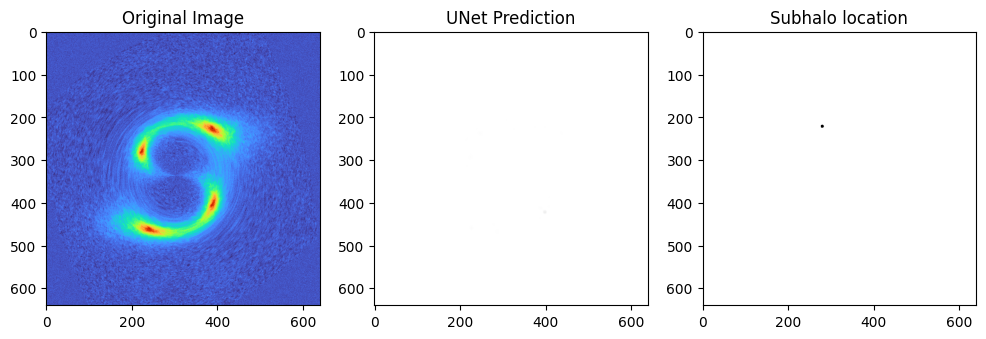

loss tensor(0.0009)
mass bin 3
x shape torch.Size([1, 1, 640, 640])
out_tens torch.Size([1, 2, 640, 640]) torch.float32
label 1 torch.Size([1, 640, 640]) torch.int32


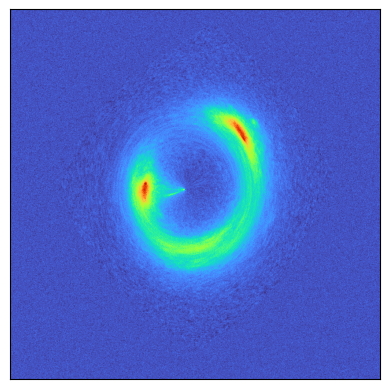

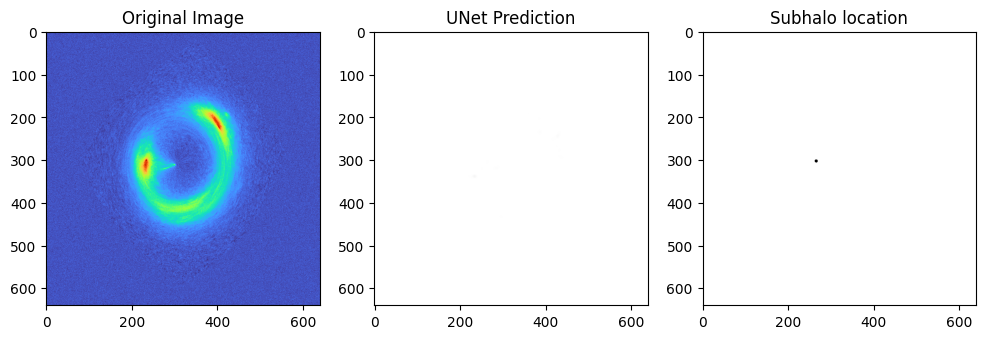

loss tensor(0.0007)
mass bin 1
x shape torch.Size([1, 1, 640, 640])
out_tens torch.Size([1, 2, 640, 640]) torch.float32
label 1 torch.Size([1, 640, 640]) torch.int32


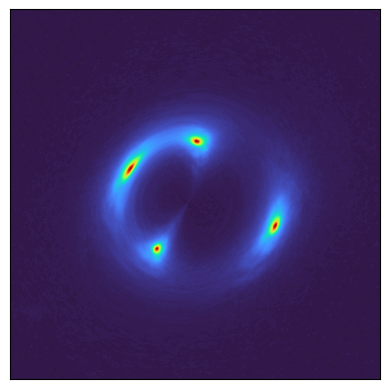

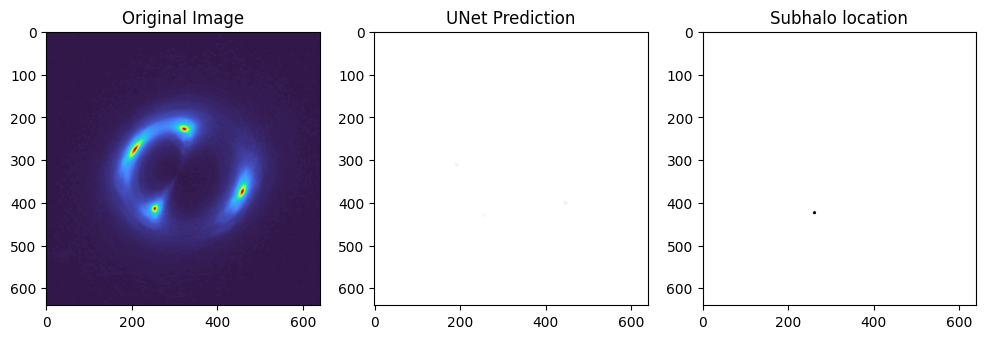

loss tensor(0.0007)
mass bin 4
x shape torch.Size([1, 1, 640, 640])
out_tens torch.Size([1, 2, 640, 640]) torch.float32
label 1 torch.Size([1, 640, 640]) torch.int32


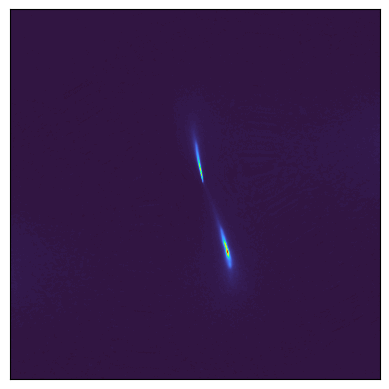

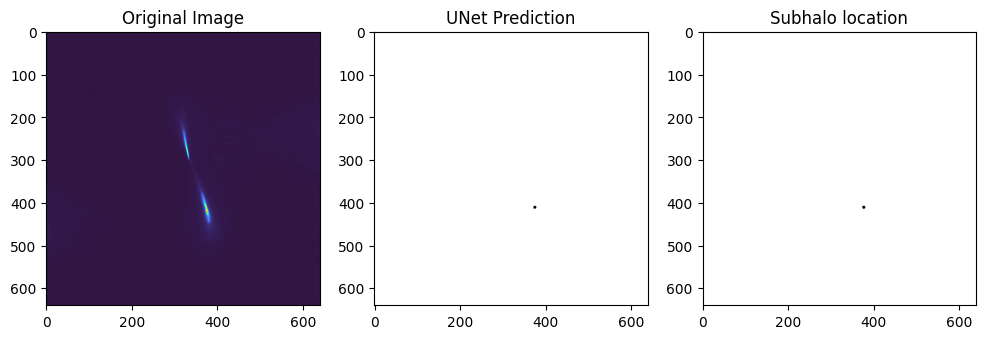

loss tensor(4.0622e-05)
mass bin 3
x shape torch.Size([1, 1, 640, 640])
out_tens torch.Size([1, 2, 640, 640]) torch.float32
label 1 torch.Size([1, 640, 640]) torch.int32


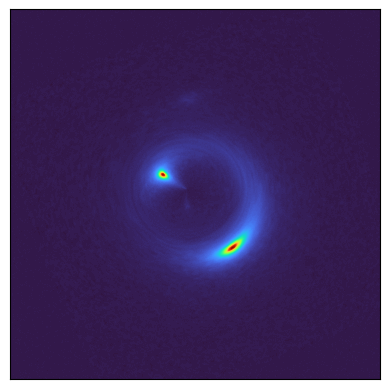

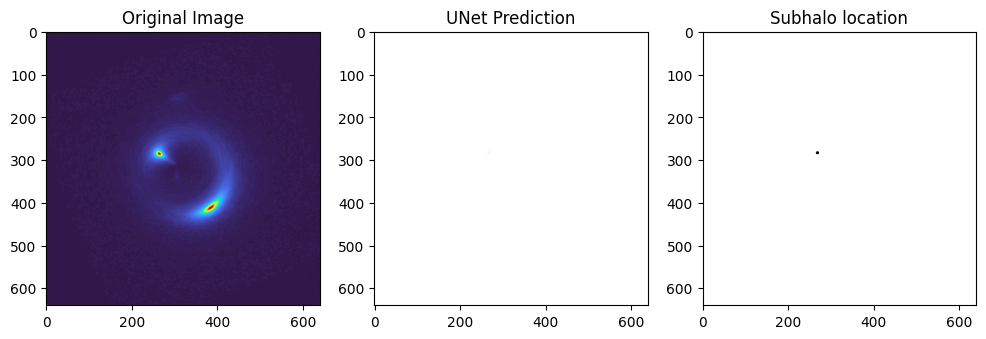

loss tensor(0.0003)
mass bin 0.0
x shape torch.Size([1, 1, 640, 640])
out_tens torch.Size([1, 2, 640, 640]) torch.float32
label 1 torch.Size([1, 640, 640]) torch.int32


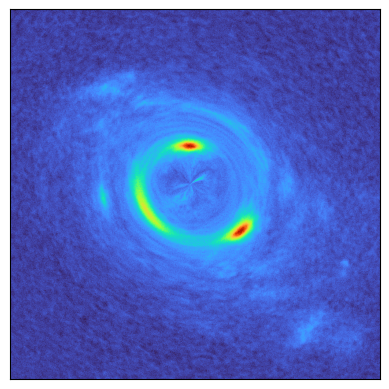

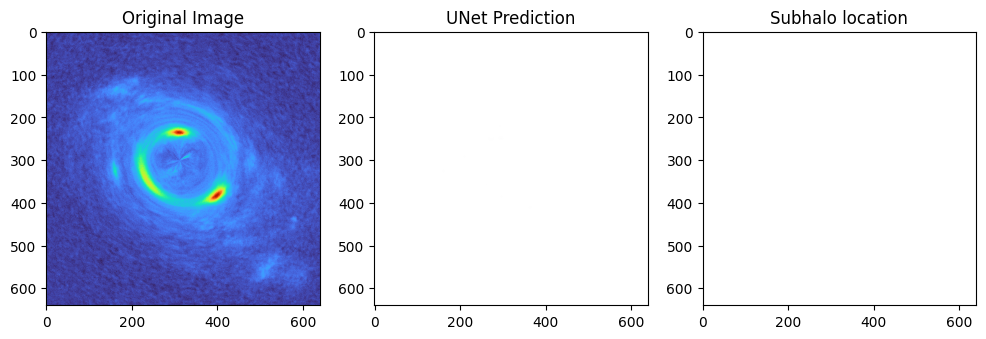

loss tensor(3.3730e-05)
average loss tensor(0.0004)


In [15]:
## Visualize "validation" data

verbose = False
show_plt = True

n_samples = 20

#criterion = torch.nn.MSELoss()
criterion = torch.nn.CrossEntropyLoss()

normalization_scale = None # 1e-5

## set the model to train mode so we can see the images that produce a low train loss
model.eval()

val_mode = True

## Loop through n_samples images to visualize them and evaluate individual losses
loss_total = 0
count = 0
with torch.no_grad():
    for i_batch, (x, label) in enumerate(val_loader if val_mode else train_loader):
        if i_batch >= n_samples/batch_size:
            break
        # if i_batch not in [10, 19, 38, 54, 60]:
        #     continue

        #print('label length', len(label), 'with dimensions', label[0].shape, label[1].shape, label[2].shape)
        #coord = label[0][0].detach().numpy()

        coord_np = np.load(os.path.join(root_dir, out_folders[1 if val_mode else 0][0], f'{data_offset+i_batch}.npy'))
        mass_bin = np.max(coord_np)
        print('mass bin', mass_bin)
        # if mass_bin !=3 and mass_bin != 0:
        #     continue
        
        ## preprocess images (normalize brightnesses)
        for i in range(len(x)):
            normalization = torch.max(x[i])
            #print('normalization', normalization)
            x[i] = x[i] / normalization
            #print('x after normalization', torch.max(x[i]))

        ## calculate output, compare with truth label
        print('x shape', x.shape)
        out_tens = model(x)
        softmaxxed = torch.nn.functional.softmax(out_tens[0], dim=0)

        print('out_tens', out_tens.shape, out_tens.dtype)
        print('label', len(label), label[0].shape, label[0].dtype)
        
        ## calculate loss
        loss = criterion(out_tens, label[0].long())
        loss_total += loss * x.shape[0]
        count += x.shape[0]

        ## show images
        for i in range(batch_size):
            
            plt.imshow(x[0, 0].detach().numpy(), 'turbo')
            plt.xticks([])
            plt.yticks([])
            
            if show_plt:
                fig, ax = plt.subplots(1,3,figsize=(12,4))
                
                ax[0].imshow(x[0, 0].detach().numpy(), 'turbo')
                #ax[0].contour(label[0].detach().numpy())
                cbar = ax[1].imshow(softmaxxed[1].detach().numpy(), 'Greys', vmin=0, vmax=1)
                #plt.colorbar(cbar, ax=ax[1])
                cbar1 = ax[2].imshow(label[0][0].detach().numpy(), 'Greys', vmin=0, vmax=1)
                #plt.colorbar(cbar1, ax=ax[2])
                
                ax[0].set_title('Original Image')
                ax[1].set_title('UNet Prediction')
                ax[2].set_title('Subhalo location')
                
                plt.show()
                print('loss', loss)
                
#             #if show_plt and np.max(coord) == 0:
#                 #print('i_batch',i_batch)
#                 probs = softmax(out_tens.detach().numpy(), axis=1)
#                 print(probs.shape)
                
#                 fig, ax = plt.subplots(1, 3, figsize=(16,4))
                
#                 #ax[0].imshow(x[0][1])
#                 #ax[0].set_title('Noisy image ({})'.format(i_batch + data_offset + n_train))
#                 ax[0].imshow(x[0][0], 'turbo')
#                 ax[0].set_title('Input')
#                 ax[1].imshow(probs[0,1], 'nipy_spectral', vmin=0, vmax=1)
#                 ax[1].set_title('UNet Output (class {})'.format(np.max(coord)))
#                 ax[2].imshow(probs[0,1], 'nipy_spectral', vmin=0, vmax=1)
#                 ax[2].contour(coord, color='white')
#                 ax[2].set_title('True position circled')

#                 plt.show()
#                 print('max prob of subhalo (figure above)',1-np.min(probs[0,0]))


        if verbose:
            print('loss batch {}: {}'.format(i_batch, loss))
    
print('average loss', loss_total / count)

The next thing I want to try is to use the low-res UNet with the high-res data, where we do the average pooling as a preprocessing step.

In [23]:
assert mname == 'bigkerUNet_bl_cat_sub_m8m11ninety_noise10_c60_hstelt_1e5_drop10_b8_f64_k3'
# or at least
assert 'hstelt' in mname and 'hstelt3' not in mname

AssertionError: 

In [128]:
val_postfix_highres = 'catval_sub_m8m11ninety_noise10_c60_hstelt3'

in_folders = ['in_' + val_postfix_highres]
out_folders = ['coord_' + val_postfix_highres]

in_size = 640
pixsize = .01

root_dir = '/n/holyscratch01/dvorkin_lab/Users/atsang/mif'

val_dataset = DatasetNoMassClass(root_dir, in_folders, out_folders,
                             ytypes=[torch.IntTensor],
                             maxlen=maxlen,
                             in_size=in_size)

val_offset = 1000000
n_val = 20
batch_size = 1

val_subset = Subset(val_dataset, range(val_offset, val_offset + n_val))
val_loader = DataLoader(val_subset, batch_size=batch_size)

mass bin 6
x shape torch.Size([1, 1, 640, 640])
x avgpooled torch.Size([1, 1, 320, 320]) tensor(1.)
out_tens torch.Size([1, 2, 320, 320]) torch.float32


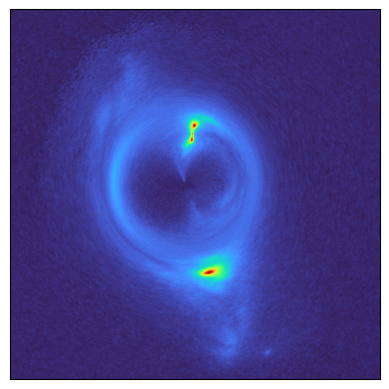

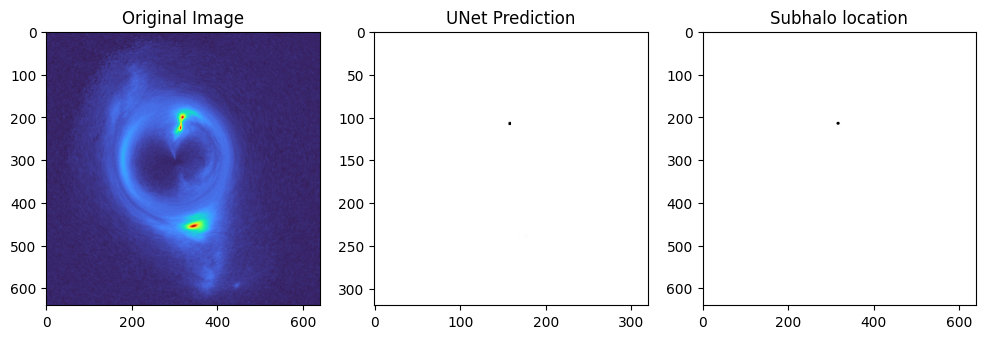

loss tensor(0.0004)
mass bin 2
x shape torch.Size([1, 1, 640, 640])
x avgpooled torch.Size([1, 1, 320, 320]) tensor(1.)
out_tens torch.Size([1, 2, 320, 320]) torch.float32


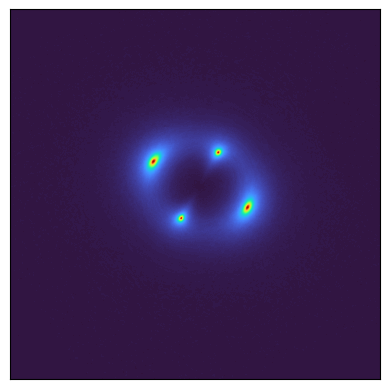

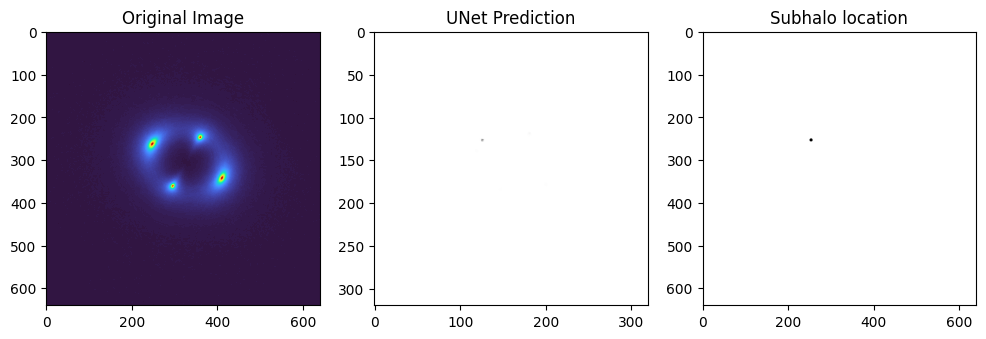

loss tensor(9.4504e-05)
mass bin 3
x shape torch.Size([1, 1, 640, 640])
x avgpooled torch.Size([1, 1, 320, 320]) tensor(1.)
out_tens torch.Size([1, 2, 320, 320]) torch.float32


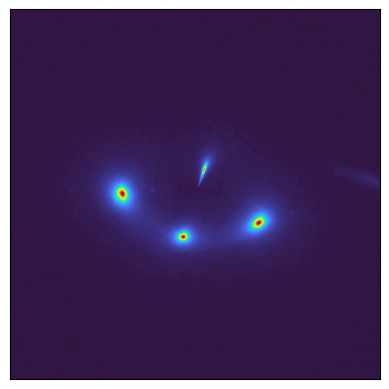

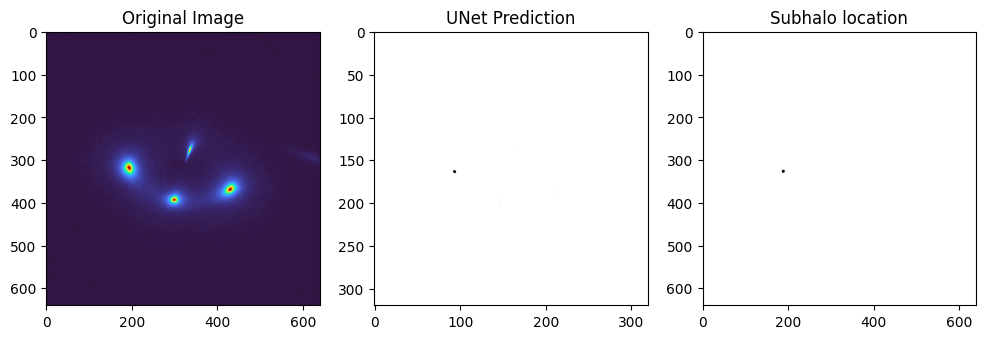

loss tensor(0.0003)
mass bin 2
x shape torch.Size([1, 1, 640, 640])
x avgpooled torch.Size([1, 1, 320, 320]) tensor(1.)
out_tens torch.Size([1, 2, 320, 320]) torch.float32


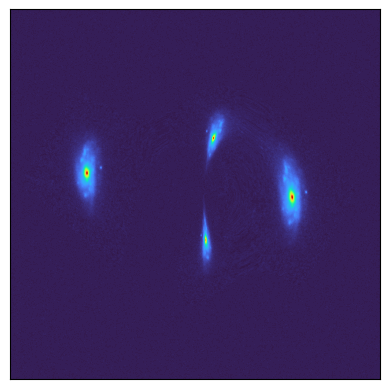

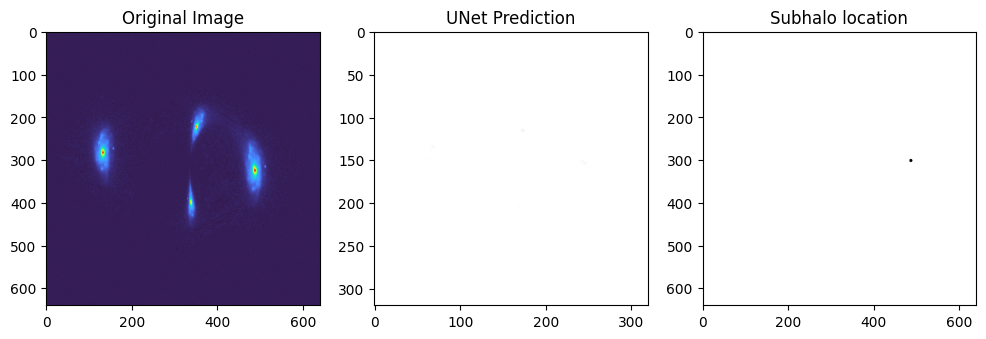

loss tensor(0.0004)
mass bin 3
x shape torch.Size([1, 1, 640, 640])
x avgpooled torch.Size([1, 1, 320, 320]) tensor(1.)
out_tens torch.Size([1, 2, 320, 320]) torch.float32


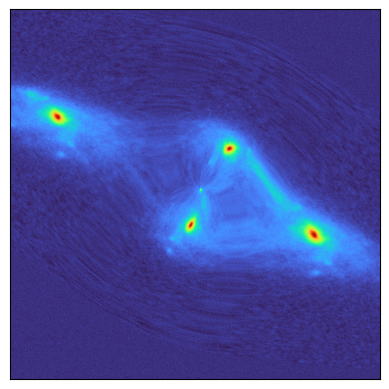

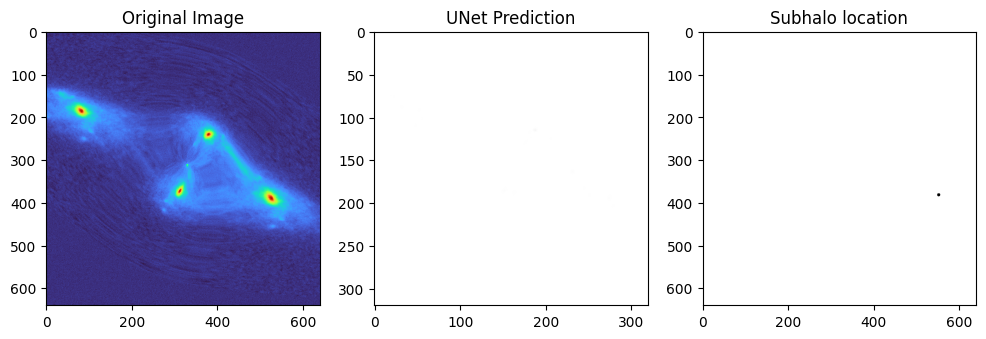

loss tensor(0.0005)
mass bin 6
x shape torch.Size([1, 1, 640, 640])
x avgpooled torch.Size([1, 1, 320, 320]) tensor(1.)
out_tens torch.Size([1, 2, 320, 320]) torch.float32


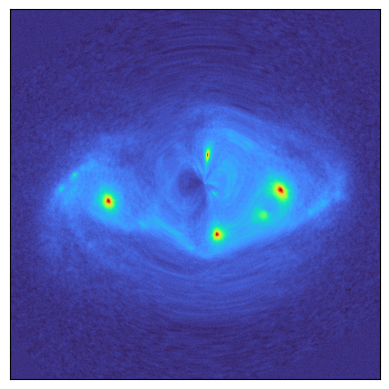

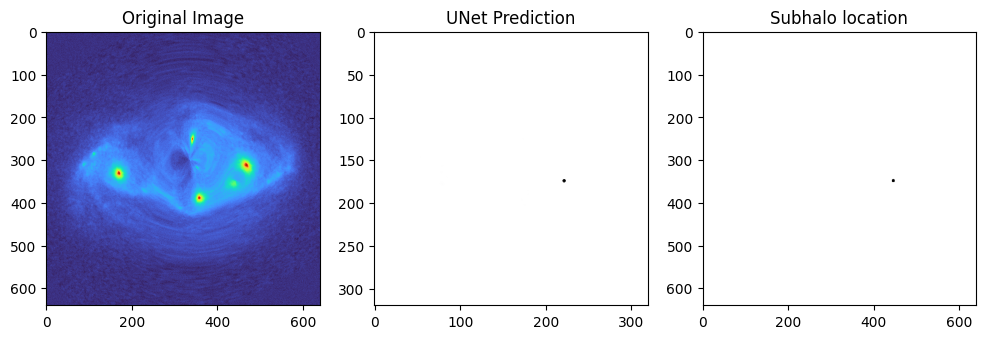

loss tensor(0.0001)
mass bin 3
x shape torch.Size([1, 1, 640, 640])
x avgpooled torch.Size([1, 1, 320, 320]) tensor(1.)
out_tens torch.Size([1, 2, 320, 320]) torch.float32


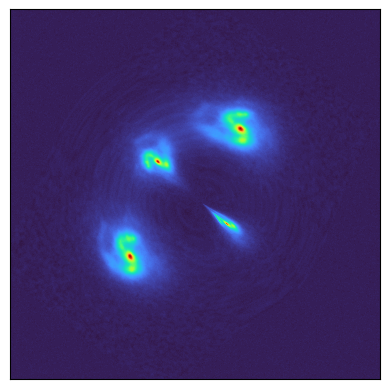

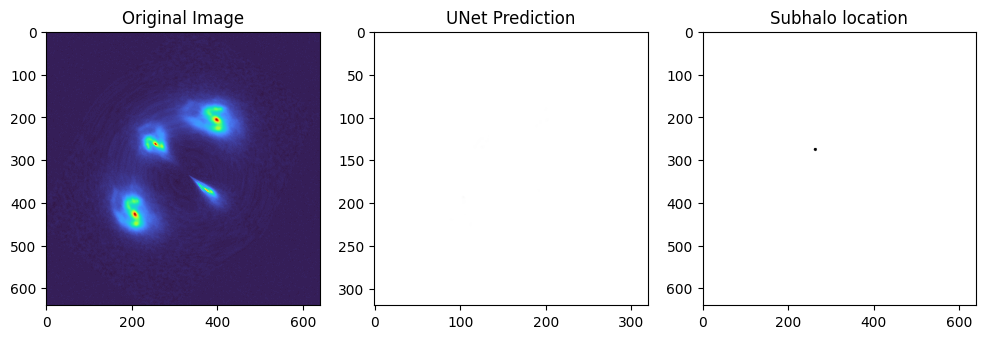

loss tensor(0.0006)
mass bin 3
x shape torch.Size([1, 1, 640, 640])
x avgpooled torch.Size([1, 1, 320, 320]) tensor(1.)
out_tens torch.Size([1, 2, 320, 320]) torch.float32


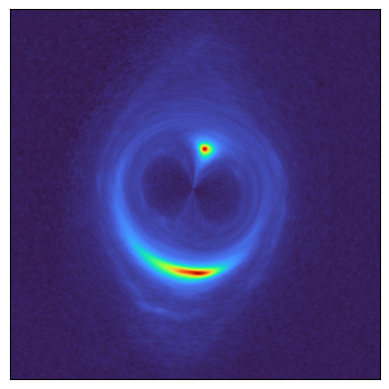

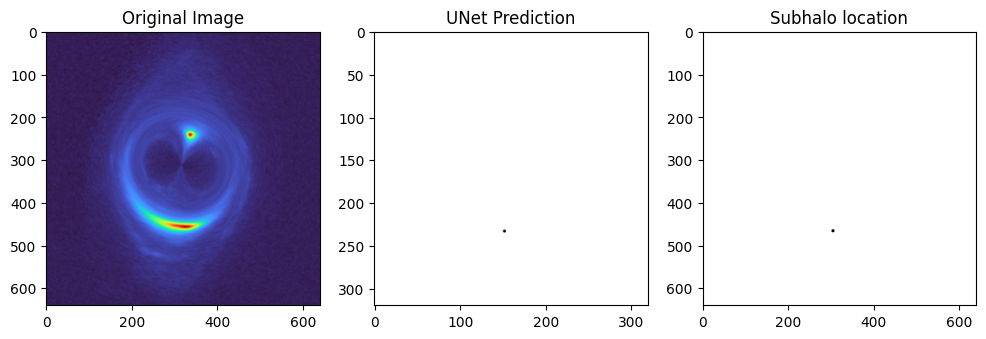

loss tensor(0.0001)
mass bin 2
x shape torch.Size([1, 1, 640, 640])
x avgpooled torch.Size([1, 1, 320, 320]) tensor(1.)
out_tens torch.Size([1, 2, 320, 320]) torch.float32


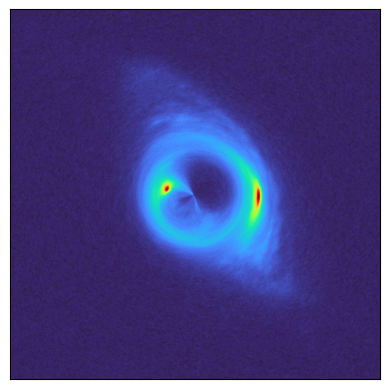

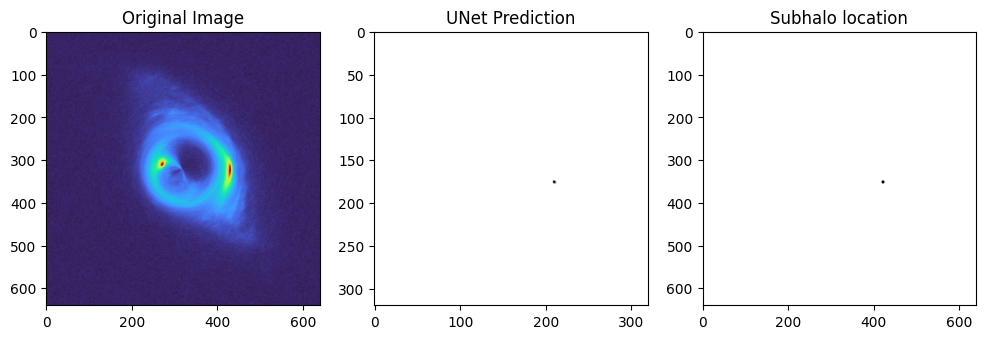

loss tensor(9.4354e-05)
mass bin 5
x shape torch.Size([1, 1, 640, 640])
x avgpooled torch.Size([1, 1, 320, 320]) tensor(1.)
out_tens torch.Size([1, 2, 320, 320]) torch.float32


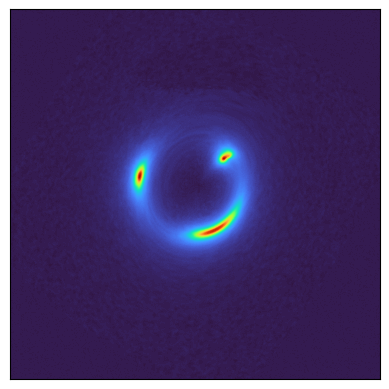

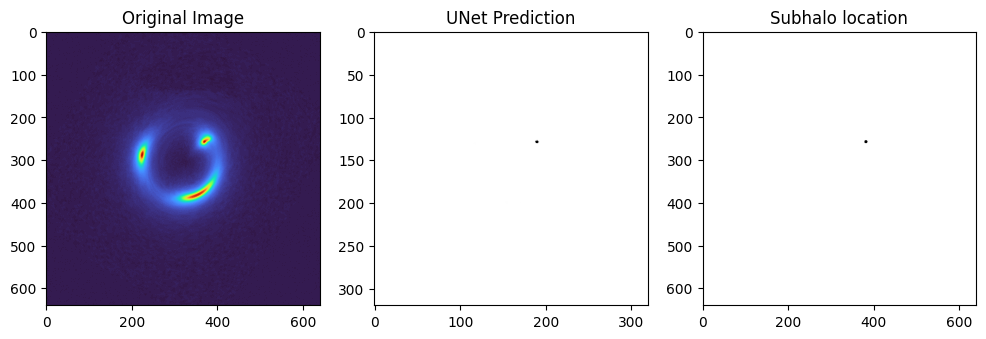

loss tensor(7.1433e-05)
mass bin 3
x shape torch.Size([1, 1, 640, 640])
x avgpooled torch.Size([1, 1, 320, 320]) tensor(1.)
out_tens torch.Size([1, 2, 320, 320]) torch.float32


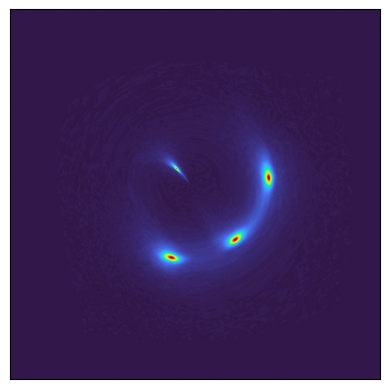

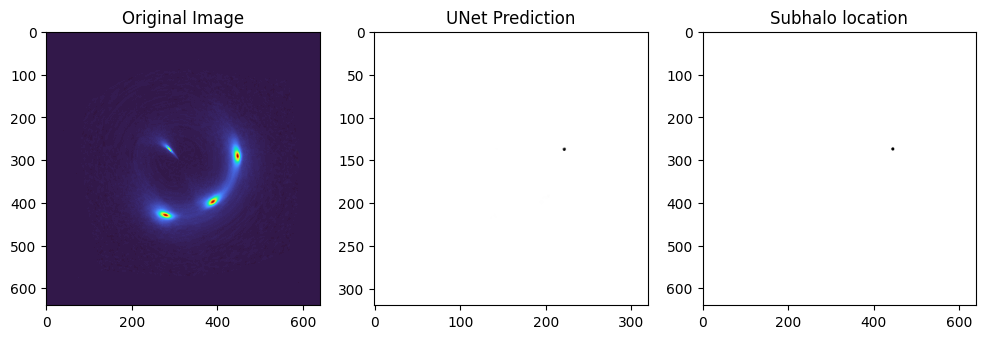

loss tensor(0.0001)
mass bin 2
x shape torch.Size([1, 1, 640, 640])
x avgpooled torch.Size([1, 1, 320, 320]) tensor(1.)
out_tens torch.Size([1, 2, 320, 320]) torch.float32


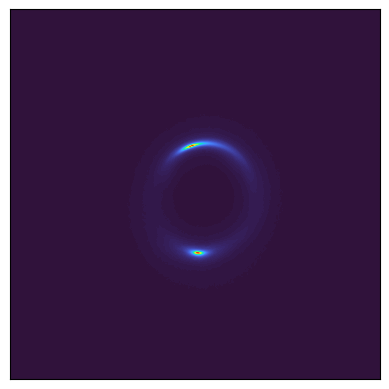

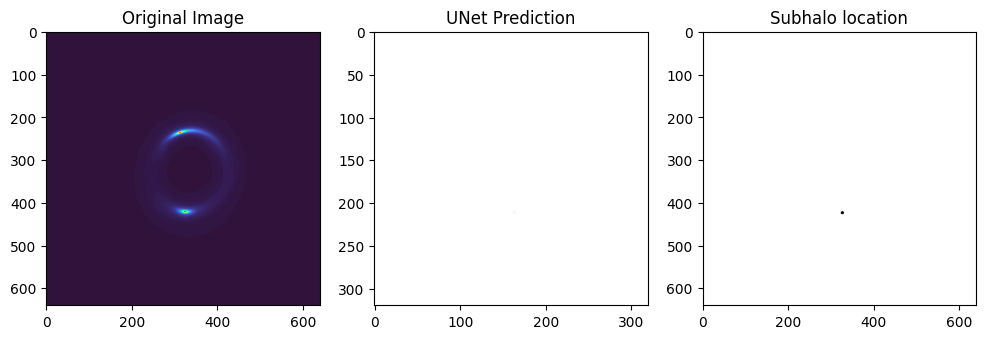

loss tensor(0.0002)
mass bin 2
x shape torch.Size([1, 1, 640, 640])
x avgpooled torch.Size([1, 1, 320, 320]) tensor(1.)
out_tens torch.Size([1, 2, 320, 320]) torch.float32


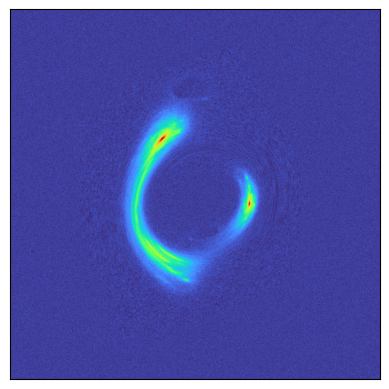

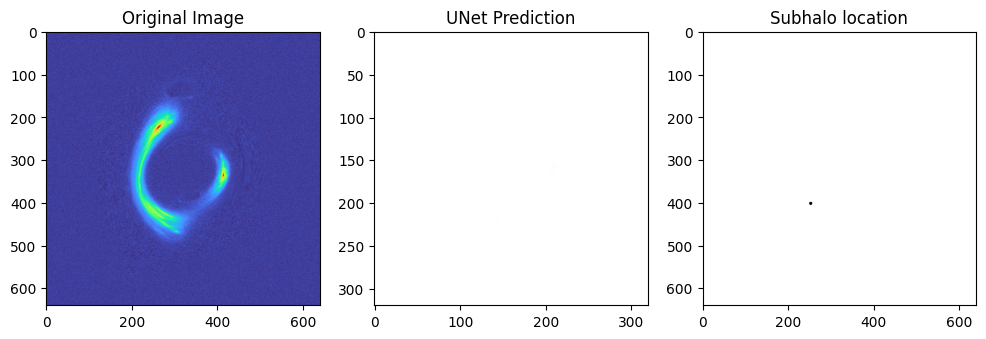

loss tensor(0.0007)
mass bin 2
x shape torch.Size([1, 1, 640, 640])
x avgpooled torch.Size([1, 1, 320, 320]) tensor(1.)
out_tens torch.Size([1, 2, 320, 320]) torch.float32


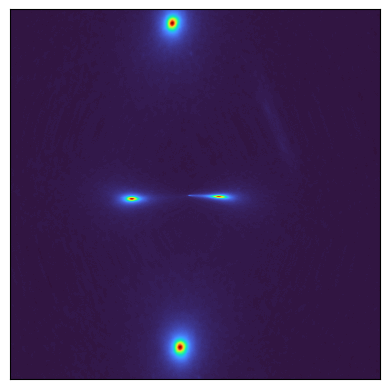

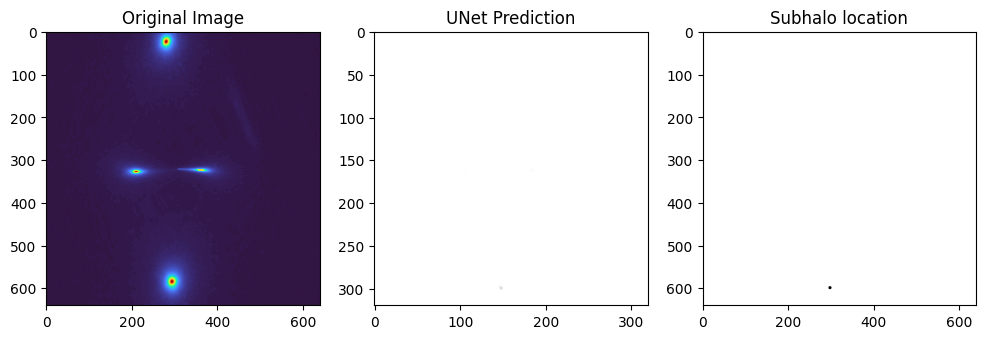

loss tensor(0.0002)
mass bin 2
x shape torch.Size([1, 1, 640, 640])
x avgpooled torch.Size([1, 1, 320, 320]) tensor(1.)
out_tens torch.Size([1, 2, 320, 320]) torch.float32


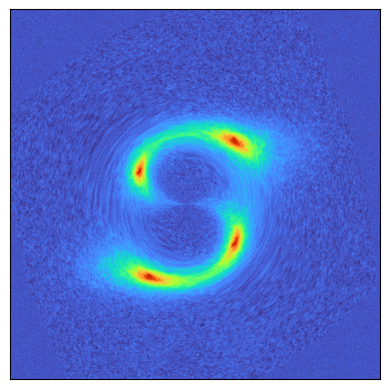

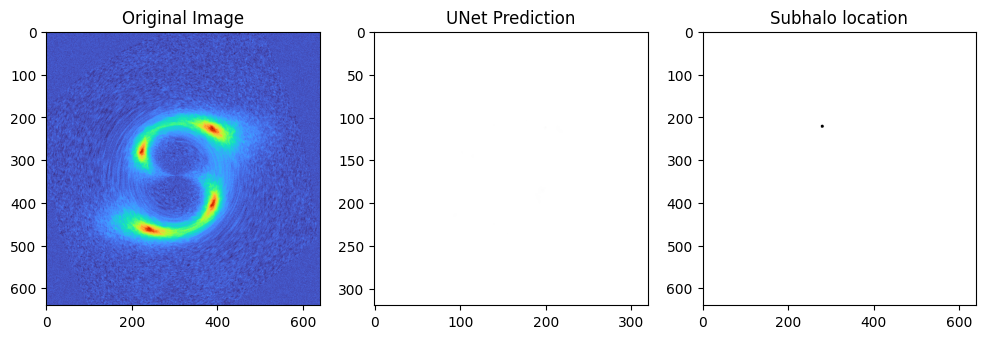

loss tensor(0.0005)
mass bin 3
x shape torch.Size([1, 1, 640, 640])
x avgpooled torch.Size([1, 1, 320, 320]) tensor(1.)
out_tens torch.Size([1, 2, 320, 320]) torch.float32


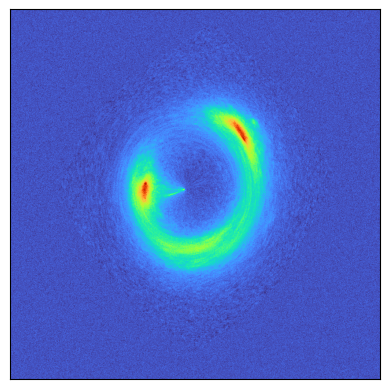

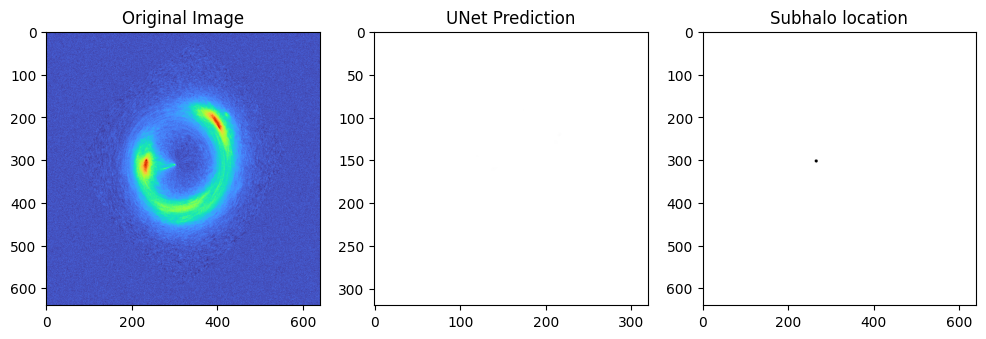

loss tensor(0.0006)
mass bin 1
x shape torch.Size([1, 1, 640, 640])
x avgpooled torch.Size([1, 1, 320, 320]) tensor(1.)
out_tens torch.Size([1, 2, 320, 320]) torch.float32


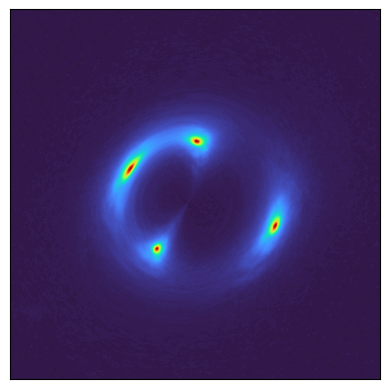

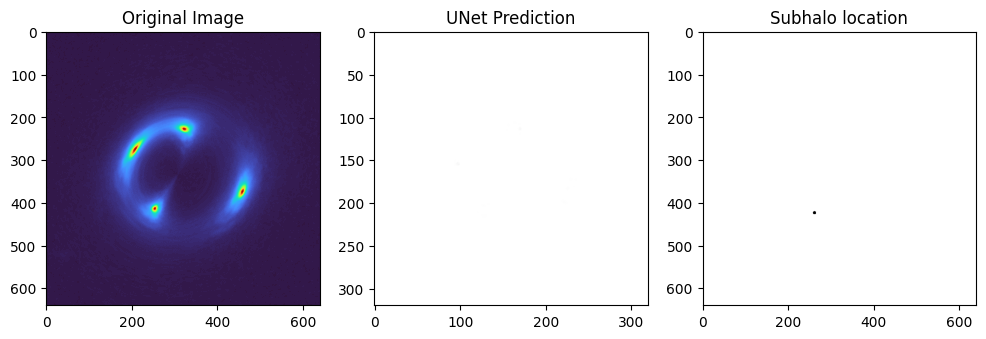

loss tensor(0.0006)
mass bin 4
x shape torch.Size([1, 1, 640, 640])
x avgpooled torch.Size([1, 1, 320, 320]) tensor(1.)
out_tens torch.Size([1, 2, 320, 320]) torch.float32


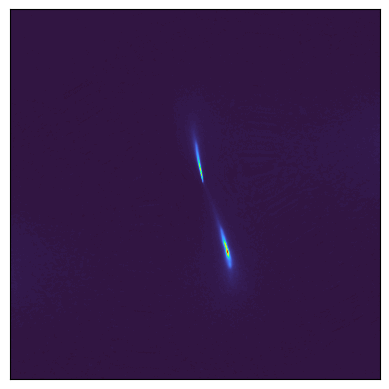

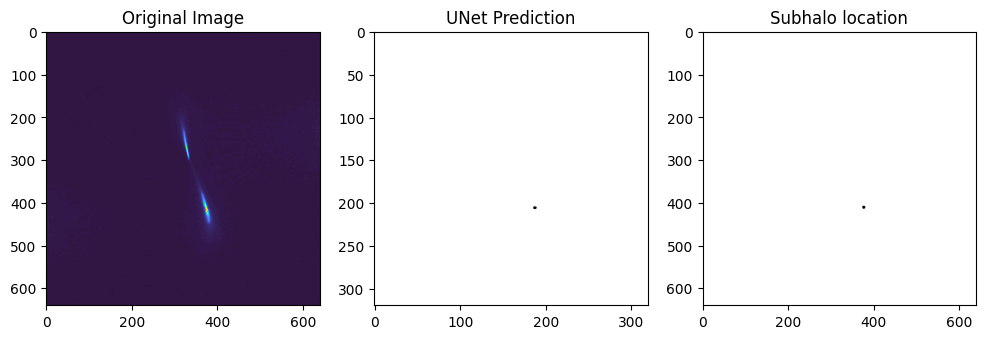

loss tensor(0.0002)
mass bin 3
x shape torch.Size([1, 1, 640, 640])
x avgpooled torch.Size([1, 1, 320, 320]) tensor(1.)
out_tens torch.Size([1, 2, 320, 320]) torch.float32


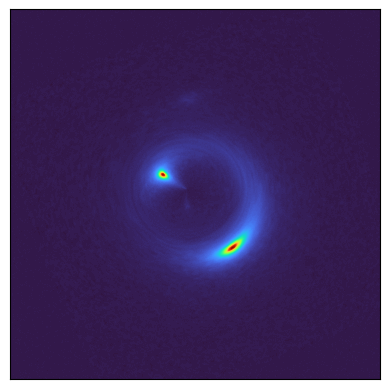

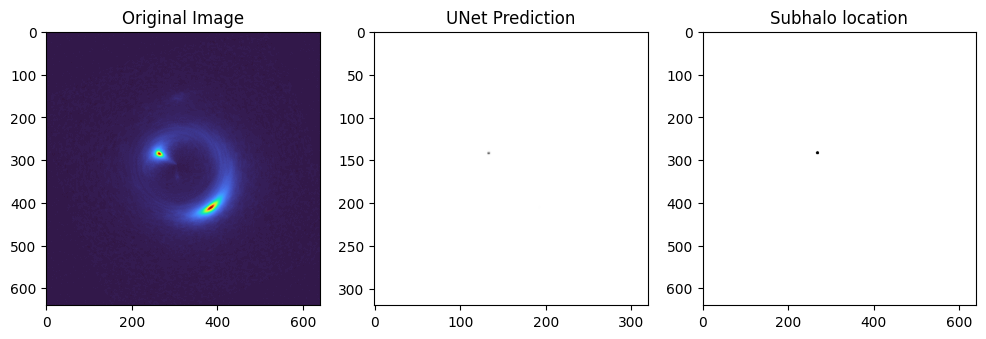

loss tensor(8.3315e-05)
mass bin 0.0
x shape torch.Size([1, 1, 640, 640])
x avgpooled torch.Size([1, 1, 320, 320]) tensor(1.)
out_tens torch.Size([1, 2, 320, 320]) torch.float32


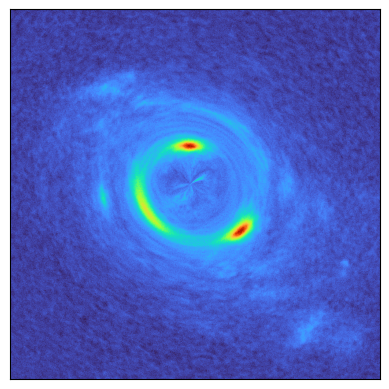

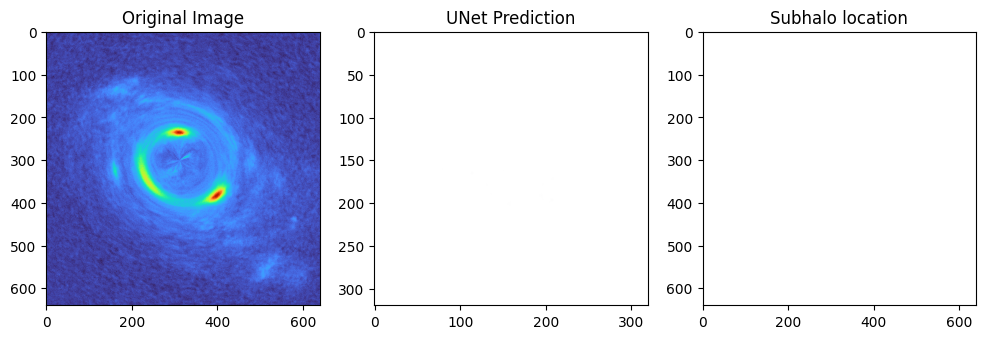

loss tensor(3.3258e-05)
average loss tensor(0.0003)


In [131]:
## Visualize "validation" data

verbose = False
show_plt = True

n_samples = 20

#criterion = torch.nn.MSELoss()
criterion = torch.nn.CrossEntropyLoss()

normalization_scale = None # 1e-5

## set the model to train mode so we can see the images that produce a low train loss
model.eval()

## Loop through n_samples images to visualize them and evaluate individual losses
loss_total = 0
count = 0
with torch.no_grad():
    for i_batch, (x, label) in enumerate(val_loader):
        if i_batch >= n_samples/batch_size:
            break
            
        coord_np = np.load(os.path.join(root_dir, out_folders[0], f'{val_offset+i_batch}.npy'))
        mass_bin = np.max(coord_np)
        print('mass bin', mass_bin)
        # if mass_bin !=3 and mass_bin != 0:
        #     continue
        
        ## preprocess images (normalize brightnesses)
        # for i in range(len(x)):
        #     normalization = torch.max(x[i]) if normalization_scale is None else normalization_scale
        #     #print('normalization', normalization)
        #     x[i] = x[i] / normalization
            #print('x after normalization', torch.max(x[i]))

        ## calculate output, compare with truth label
        print('x shape', x.shape)
        x_avgpool = torch.nn.functional.avg_pool2d(x, kernel_size=2)
        x_avgpool = x_avgpool / torch.max(x_avgpool)
        print('x avgpooled', x_avgpool.shape, torch.max(x_avgpool))
        out_tens = model(x_avgpool)
        softmaxxed = torch.nn.functional.softmax(out_tens[0], dim=0)

        label_avgpool = torch.nn.functional.avg_pool2d(label[0].long(), kernel_size=2)
        
        print('out_tens', out_tens.shape, out_tens.dtype)
        
        ## calculate loss
        loss = criterion(out_tens, label_avgpool)
        loss_total += loss * x.shape[0]
        count += x.shape[0]

        ## show images
        for i in range(batch_size):
            
            plt.imshow(x[0, 0].detach().numpy(), 'turbo')
            plt.xticks([])
            plt.yticks([])
            
            if show_plt:
                fig, ax = plt.subplots(1,3,figsize=(12,4))
                
                ax[0].imshow(x[0, 0].detach().numpy(), 'turbo')
                #ax[0].contour(label[0].detach().numpy())
                cbar = ax[1].imshow(softmaxxed[1].detach().numpy(), 'Greys', vmin=0, vmax=1)
                #plt.colorbar(cbar, ax=ax[1])
                cbar1 = ax[2].imshow(label[0][0].detach().numpy(), 'Greys', vmin=0, vmax=1)
                #plt.colorbar(cbar1, ax=ax[2])
                
                ax[0].set_title('Original Image')
                ax[1].set_title('UNet Prediction')
                ax[2].set_title('Subhalo location')
                
                plt.show()
                print('loss', loss)

        if verbose:
            print('loss batch {}: {}'.format(i_batch, loss))
    
print('average loss', loss_total / count)

## Old cells

In [42]:
!readlink -f ~/lfslink/mif

/n/holyscratch01/dvorkin_lab/Users/atsang/mif


In [ ]:
## Try targeted model on target image

target_in = np.load(f'/n/holyscratch01/dvorkin_lab/Users/atsang/mif/in_narrowcat_subc_m6m10_noise10_c60_fakeelt/{seed}.npy')

In [ ]:
plt.imshow(target_in, 'turbo')
plt.title('Original image')

In [ ]:
target_in_torch = torch.from_numpy(target_in / np.max(target_in))[None, None].float()
res = model(target_in_torch)[0]
probs = softmax(res.detach().numpy(), axis=0)

In [ ]:
for i in range(9):
    plt.imshow(probs[i], vmin=0, vmax=1)
    plt.title(f'Class {i}')
    plt.colorbar()
    plt.show()

In [22]:
target_coord = np.load(f'/n/holyscratch01/dvorkin_lab/Users/atsang/mif/coord_narrowcat_subc_m6m10_noise10_c60/{seed}.npy')

Text(0.5, 1.0, 'True subhalo location')

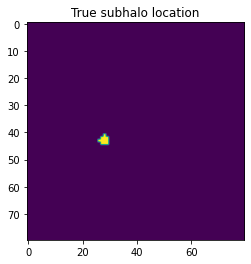

In [23]:
plt.imshow(target_coord)
plt.title('True subhalo location')

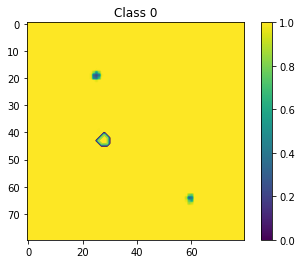

1.0


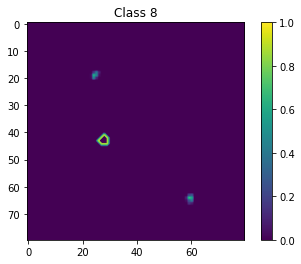

0.69527376


In [24]:
for i in [0,8]:
    plt.imshow(probs[i], vmin=0, vmax=1)
    plt.title(f'Class {i}')
    plt.colorbar()
    plt.contour(target_coord)
    plt.show()
    print(np.max(probs[i]))

normalization tensor(2.4423)
x after normalization tensor(1.)


IndexError: list index out of range

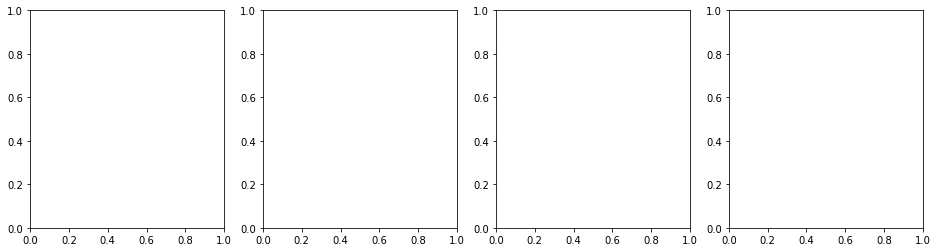

In [25]:
## Visualize "validation" data

verbose = False
show_plt = True
daf_stack = False

n_samples = 200

criterion = torch.nn.MSELoss()

normalization_scale = None # 1e-5

## set the model to train mode so we can see the images that produce a low train loss
model.eval()

## Loop through n_samples images to visualize them and evaluate individual losses
loss_total = 0
count = 0
with torch.no_grad():
    for i_batch, (x, label) in enumerate(val_loader):
        if i_batch >= n_samples/batch_size:
            break

        #print('label length', len(label), 'with dimensions', label[0].shape, label[1].shape, label[2].shape)
        coord = label[0][0].detach().numpy()

        ## preprocess images (normalize brightnesses)
        for i in range(len(x)):
            normalization = torch.max(x[i]) if normalization_scale is None else normalization_scale
            print('normalization', normalization)
            x[i] = x[i] / normalization
            print('x after normalization', torch.max(x[i]))

        ## calculate output, compare with truth label
        out_tens = model(x)

        ## calculate loss
        loss = criterion(out_tens, label[0].float())
        loss_total += loss * x.shape[0]
        count += x.shape[0]

        ## show images
        for i in range(batch_size):
            if show_plt:
            #if show_plt and np.max(coord) >= 7:
                probs = softmax(out_tens.detach().numpy(), axis=1)
                
                fig, ax = plt.subplots(1, 4, figsize=(16,4))
                
                ax[0].imshow(label[1][0])
                ax[0].set_title('Noisy image ({})'.format(i_batch + data_offset + n_train))
                ax[1].imshow(x[0,0], vmin=0, vmax=1)
                ax[1].set_title(r'$\Delta$ Convergence')
                ax[2].imshow(probs[0,np.max(coord)], vmin=0)
                ax[2].set_title('UNet Output (class {})'.format(np.max(coord)))
                ax[3].imshow(probs[0,np.max(coord)], vmin=0, vmax=1/9)
                ax[3].contour(coord)
                ax[3].set_title('True position circled')

                plt.show()


        if verbose:
            print('loss batch {}: {}'.format(i_batch, loss))
    
print('average loss', loss_total / count)

## Pixel accuracies

In [ ]:
## Visualize "validation" data

raise NotImplementedError

verbose = False
show_plt = True

n_samples = 2 # 200

criterion = torch.nn.MSELoss()

model.eval()

## Loop through n_samples images to visualize them and evaluate individual losses
pix_pos_rates = [] # true pos and false pos
with torch.no_grad():
    for i_batch, (x, label) in enumerate(val_loader):
        if i_batch >= n_samples/batch_size:
            break

        coord = label[0][0].detach().numpy()

        ## preprocess images (normalize brightnesses)
        for i in range(len(x)):
            x[i] = x[i] / torch.max(x[i])

        ## calculate output, compare with truth label
        out_tens = model(x)
        
        ## calculate output as discrete labeling
        probs = softmax(out_tens.detach().numpy(), axis=1)
        predictions = np.argmax(probs, axis=1)

        # print('shapes', out_tens.shape,'probs', probs.shape, 'pred', predictions.shape)
        
        # print(np.max(coord))
        
#         ## Right now, I'll write this assuming just binary labels
#         false_pos_cnt = np.sum(predictions * (1 - coord))
#         true_pos_cnt = np.sum(predictions * coord)
        
#         pix_pos_rates.append((false_pos_cnt / np.sum(coord), true_pos_cnt / np.sum(coord)))

In [ ]:
pix_pos_rates = np.array(pix_pos_rates)

In [ ]:
plt.scatter(pix_pos_rates[:,0], pix_pos_rates[:,1], alpha=.1)
plt.xlabel('False pos pixels / True subhalo pixels')
plt.ylabel('True pos pixels / True subhalo pixels')

In [20]:
xedges = [0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1.0, 1.1, 1.2]
yedges = [0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1.0]
hist, xedges, yedges = np.histogram2d(pix_pos_rates[:,0], pix_pos_rates[:,1], bins=(xedges, yedges))

Text(0, 0.5, 'True pos pixels / True subhalo pixels')

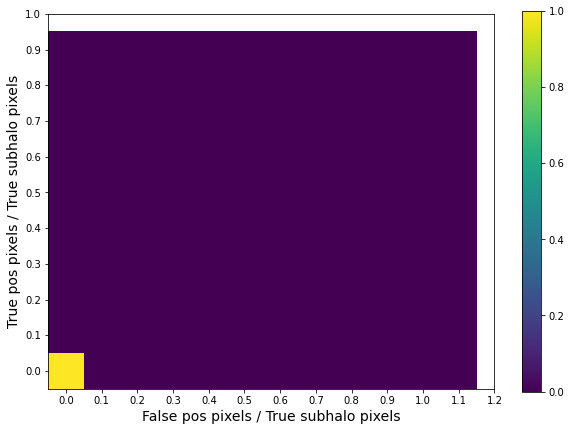

In [21]:
plt.figure(figsize=(10, 7))
plt.imshow(hist.T / np.sum(hist), origin='lower')
plt.colorbar()
plt.xticks(ticks=np.arange(len(xedges)), labels=xedges)
plt.yticks(ticks=np.arange(len(yedges)), labels=yedges);
#plt.title('')
plt.xlabel('False pos pixels / True subhalo pixels', fontsize=14)
plt.ylabel('True pos pixels / True subhalo pixels', fontsize=14)

How many "good" images do we have under this fairly strict definition?

In [22]:
is_good = np.array([(x < 0.5 and y > 0.5) for x,y in pix_pos_rates])

In [23]:
np.sum(is_good) / len(is_good)

0.53

Ok, this is probably too strict, but we'll get to that later.

And now collect data about their masses.

In [24]:
from data_gen_bright import gen_image_general

In [25]:
seed = 9000
params = gen_image_general(seed, True, 1e10, 'varyg2clump', constraints={'num_exposures':10}, mode='macro params')

In [26]:
params[16]

0.5315590540858737

In [27]:
mass_multiplier_idx = 16
mass_multipliers = np.array(
    [gen_image_general(seed, True, 1e10, 'varyg2clump', constraints={'num_exposures':10}, mode='macro params')[mass_multiplier_idx]
        for seed in range(9000, 9200)])

(array([ 0.,  0.,  6.,  3.,  2., 10.,  4.,  7.,  9.,  2.,  5.,  3.,  4.,
         4.,  8.,  6.,  4.,  4.,  6.,  7.]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),
 [<matplotlib.patches.Polygon at 0x2b98d10b2940>])

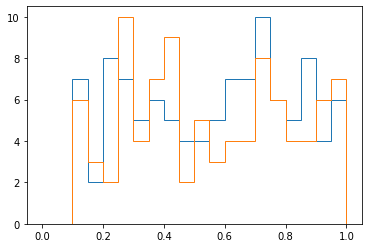

In [28]:
bins = np.arange(0, 1.01, .05)
plt.hist(mass_multipliers[is_good], bins=bins, histtype='step')
plt.hist(mass_multipliers[np.logical_not(is_good)], bins=bins, histtype='step')

In [29]:
is_good_lax = np.array([(x > .01 and y > .01) for x,y in pix_pos_rates])

(array([0., 0., 5., 2., 2., 9., 2., 4., 3., 2., 3., 2., 3., 3., 4., 2., 2.,
        0., 3., 3.]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),
 [<matplotlib.patches.Polygon at 0x2b98d124f4f0>])

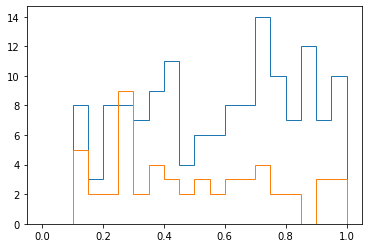

In [30]:
bins = np.arange(0, 1.01, .05)
plt.hist(mass_multipliers[is_good_lax], bins=bins, histtype='step')
plt.hist(mass_multipliers[np.logical_not(is_good_lax)], bins=bins, histtype='step')